<a href="https://colab.research.google.com/github/TanushGoel/PharmaceuticAI/blob/master/PharmaceuticAI_CuDNNLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SMILES Notes:**

SMILES = Simplified Molecular Input Line Entry Specification

*   Atoms are shown by atomic symbols
*   Hydrogen atoms are assumed to fill spare valencies
*   Adjacent atoms are connected by single bonds
  *   double bonds are shown by "="
  *   triple bonds are shown by "#"
*   Branching is indicated by parenthesis
*   Ring closures are shown by pairs of matching digits


[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#/media/File:SMILES.png)









In [1]:
# install conda on google colab
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-08-21 17:47:18--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   134MB/s    in 0.6s    

2020-08-21 17:47:19 (134 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [2]:
!conda install -q -c rdkit rdkit -y # for molecule analysis and visualization

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    bzip2-1.0.8                |       h7b6447c_0          78 KB
    ca-certificates-2020.6.24  |                0         125 KB
    cairo-1.14.12              |       h8948797_3         906 KB
    certifi-2020.6.20          |           py37_0         156 KB
    conda-4.8.4                |           py37_0         2.9 MB
    fontconfig-2.13.0          |       h9420a91_0         227 KB
    freetype-2.10.2            |       h5ab3

In [3]:
!pip3 install -q chembl_webresource_client # https://www.ebi.ac.uk/chembl/

     |████████████████████████████████| 61kB 3.3MB/s 


In [4]:
# imports
import pandas as pd
import os
from os import path
import zipfile
import glob
import json
import numpy as np
import random
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from collections import Counter
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps, IPythonConsole
from chembl_webresource_client.new_client import new_client
from google.colab import files

# suppress rdkit error messages
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

In [5]:
tf.__version__

'2.3.0'

In [6]:
tf.keras.__version__

'2.4.0'

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [9]:
!nvidia-smi

Fri Aug 21 17:49:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
# double letters for one element turned into single letters that are not in the dataset
double_to_single = {'Si':'q', 'Se':'w', 'Cn':'t', 'Sc':'y', 'Cl':'u', 'Sn':'z', 'Br':'x'} 
single_to_double = {'q':'Si', 'w':'Se', 't':'Cn', 'y':'Sc', 'u':'Cl', 'z':'Sn', 'x':'Br'}
elements_with_double_letters = list(double_to_single)

In [11]:
element_set = ['C', '(', '=', 'O', ')', 'N', 'c', '1', '$', '2', '3', '4', '#', 'n', 'F', 'u', '-', '[', 'H', ']', 's', 'o', 'S', 't', '5', '6', '+', 'P', 'I', 'x', 'y', 'q', 'B', 'w', '7', '8', 'e', '9', 'b', 'p', '%', '0', 'z']
n_vocab = len(element_set)
element_to_int = dict(zip(element_set, range(0, n_vocab)))
int_to_element = {v: k for k, v in element_to_int.items()}
sequence_length = 100 

In [23]:
filey = open('pharmaceuticAI_all_compounds.smiles')
structures = [line[:-1] for line in filey]
print("Num Total Samples:", len(structures))
filey.close()

Num Total Samples: 1591378


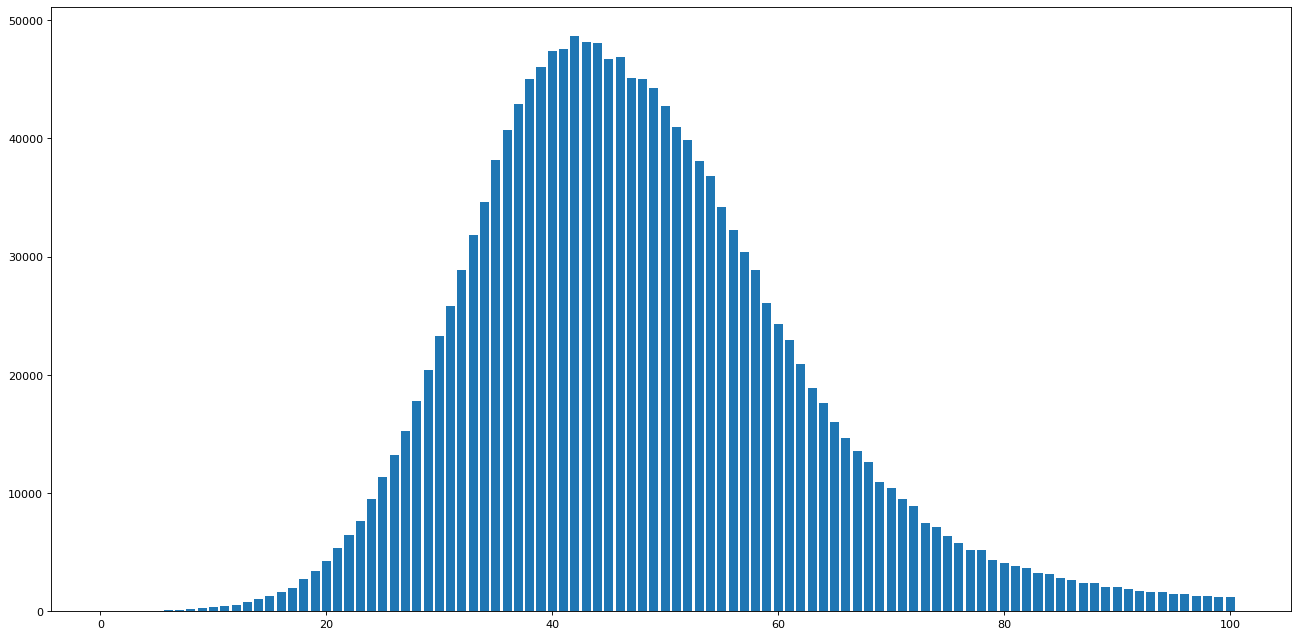

In [24]:
# distribution of molecule sequence lengths
lengths = [len(i) for i in structures]
c = Counter(lengths)
plt.figure(figsize=(20, 10), dpi=80)
plt.bar(c.keys(), c.values())
plt.show()

In [25]:
def gen_structs(data):

    structs = []
    for structure in data:
        i = 0
        while i < len(structure):
            try:
                if structure[i] + structure[i+1] in elements_with_double_letters:
                    structs.append(double_to_single[structure[i] + structure[i+1]])
                    i+=2
                else:
                    structs.append(structure[i])
                    i+=1
            except:
                    structs.append(structure[i])
                    i+=1
        structs.append("$") # end token

    return structs

def gen_data(structs):

    network_inp = []
    network_outp = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(structs) - sequence_length):
        sequence_in = structs[i:i + sequence_length]
        sequence_out = structs[i + sequence_length]
        network_inp.append([element_to_int[char] for char in sequence_in])
        network_outp.append(element_to_int[sequence_out])
        
    n_patterns = len(network_inp)

    # reshape the input into a format compatible with CuDNNLSTM layers
    network_inp = np.reshape(network_inp, (n_patterns, sequence_length))

    return network_inp, network_outp

def one_hot(network_out):

      network_out = np_utils.to_categorical(network_out, n_vocab)

      return network_out

In [26]:
num_train = 1550000
batch_siz = 50000

valid = structures[num_train:]
random.shuffle(valid) # changes sequences a little

train_all = structures[:num_train]
del structures
random.shuffle(train_all) # change sequences a little

valid_input, valid_output = gen_data(gen_structs(valid))

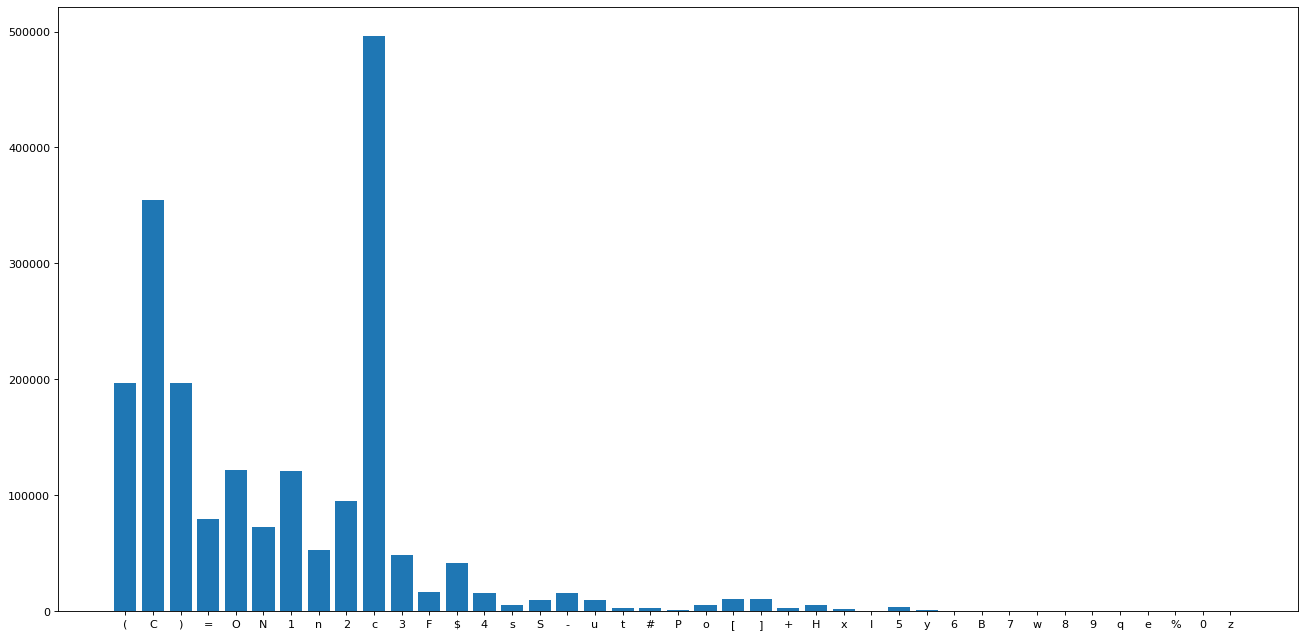

In [27]:
# class distributions valid
c = Counter(valid_output)
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([int_to_element[j] for j in c.keys()], c.values())
plt.show()

In [28]:
valid_output = one_hot(valid_output)

In [29]:
smiles_input = layers.Input(shape=(sequence_length,), dtype='int32', name='smiles_input')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_smiles = layers.Embedding(output_dim=128, input_dim=n_vocab, input_length=sequence_length)(smiles_input) 

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
conv1_smiles = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(embed_smiles)
activation1_smiles = layers.PReLU()(conv1_smiles)
dropout1 = layers.Dropout(0.1)(activation1_smiles)
conv2_smiles = tf.compat.v1.keras.layers.CuDNNLSTM(512, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(dropout1)
activation2_smiles = layers.PReLU()(conv2_smiles)
dropout2 = layers.Dropout(0.1)(activation2_smiles)
conv3_smiles = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(dropout2)
activation3_smiles = layers.PReLU()(conv3_smiles)
dropout3 = layers.Dropout(0.1)(activation3_smiles)

# turn into vector
flatten = layers.Flatten()(dropout3)

# dense layers 
dense1 = layers.Dense(512, activation='relu')(flatten)
dropout1_dense = layers.Dropout(0.1)(dense1)
dense2 = layers.Dense(256, activation='relu')(dropout1_dense)

# output
output = layers.Dense(n_vocab, activation="softmax", name='output')(dense2) 

model = Model(inputs=smiles_input, outputs=[output])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
smiles_input (InputLayer)    [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          5504      
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 100, 256)          395264    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 100, 256)          25600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 100, 512)          1576960   
_________________________________________________________________
p_re_lu_4 (PReLU)            (None, 100, 512)         

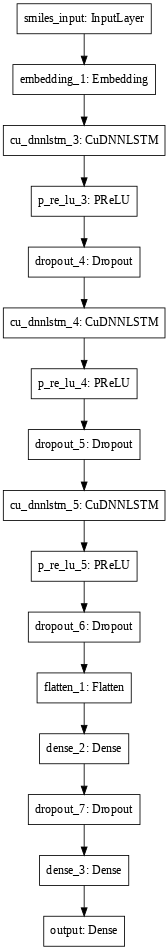

In [30]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60)

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [32]:
# checkpointer
save_model_path = "SMILES-best.hdf5"
checkpoint = ModelCheckpoint(save_model_path, 
                             monitor='val_loss', 
                             verbose=1,        
                             save_best_only=True)

In [33]:
# load best model
# if first time, do not run this cell
model.load_weights("SMILES-best.hdf5")

In [ ]:
train_index_start = 0
train_index_end = batch_siz
while train_index_end < num_train:

    train = train_all[train_index_start:train_index_end]
    random.shuffle(train) # changes sequences a little

    network_input, network_output = gen_data(gen_structs(train))
    network_output = one_hot(network_output)

    # train model on batch
    model.fit(network_input, 
              network_output, 
              validation_data=(valid_input, valid_output),
              epochs=1, 
              batch_size=64,
              shuffle=False,
              callbacks=[checkpoint])

    train_index_start += batch_siz
    train_index_end += batch_siz

In [ ]:
# if the model on the last batch wasn't the best, still save the model including the batch anyways - unless it is your final run-through
model.save_weights("SMILES-best.hdf5")

In [ ]:
files.download(save_model_path) 

## Molecule Analysis Methods

In [34]:
melatonin = "COC1=CC2=C(NC=C2CCNC(C)=O)C=C1"
glycogen = "C(C1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3C(OC(C(C3O)O)O)CO)O)O)OC4C(C(C(C(O4)CO)O)O)O)O)O)O)O"
penicillin = "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"

In [83]:
def test_molecule(molecule):
    if molecule == None or len(molecule) <= 3:
        return False
    mol = Chem.MolFromSmiles(molecule)
    if mol == None:
        return False
    else:
        try:
            Draw.MolToImage(mol) # if molecule is not drawable, the molecule is not valid
            return True
        except:
            return False
      
print(test_molecule(penicillin))
print(test_molecule("abc123"))

True
False


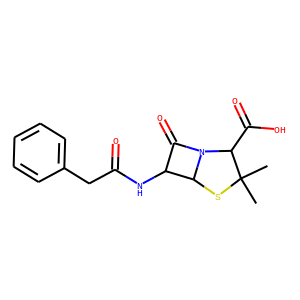

In [36]:
def draw_compound(molecule):
    m = Chem.MolFromSmiles(molecule)
    weight = Descriptors.MolWt(m)
    return Draw.MolToImage(m)
  
draw_compound(penicillin) 

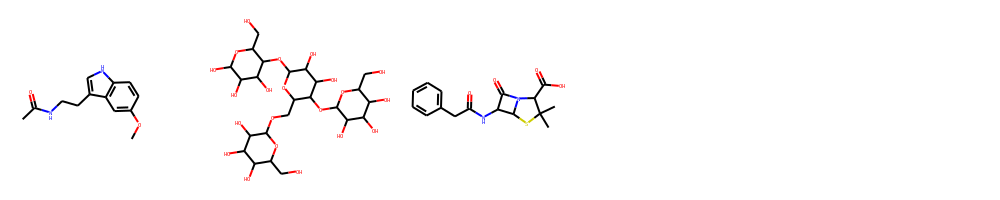

In [37]:
def draw_list_compounds(molecules):
  list_molecules = []
  for i in molecules:
     list_molecules.append(Chem.MolFromSmiles(i))
  return Draw.MolsToGridImage(list_molecules, molsPerRow=5)

draw_list_compounds([melatonin, glycogen, penicillin])

In [38]:
def analyze_compound(molecule):
  m = Chem.MolFromSmiles(molecule)
  print("Molecule Weight:", Descriptors.MolWt(m), "g/mol")
  print("Num Atoms:", m.GetNumAtoms())
  print("LogP:", Descriptors.MolLogP(m))
  print("TPSA:", Descriptors.TPSA(m))

analyze_compound(penicillin)

Molecule Weight: 334.39700000000005 g/mol
Num Atoms: 23
LogP: 0.8607999999999993
TPSA: 86.71000000000001


In [39]:
def get_h_bond_donors(mol):
    idx = 0
    donors = 0
    while idx < len(mol)-1:
        if mol[idx].lower() == "o" or mol[idx].lower() == "n":
            if mol[idx+1].lower() == "h":
                donors+=1
        idx+=1
    return donors

def get_h_bond_acceptors(mol):
    acceptors = 0
    for i in mol:
        if i.lower() == "n" or i.lower() == "o":
            acceptors+=1
    return acceptors

# Lipinski's “Rule of Five” - Constraints in order to maintain drug-like character within the compounds
def rule_of_five(molecule):
    m = Chem.MolFromSmiles(molecule)
    if get_h_bond_donors(molecule) <= 5 and get_h_bond_acceptors(molecule) <= 10 and Descriptors.MolWt(m) <= 500 and Descriptors.MolLogP(m) <= 5:
        return True
    else:
        return False

print(rule_of_five(melatonin))
print(rule_of_five(glycogen))
print(rule_of_five(penicillin))

True
False
True


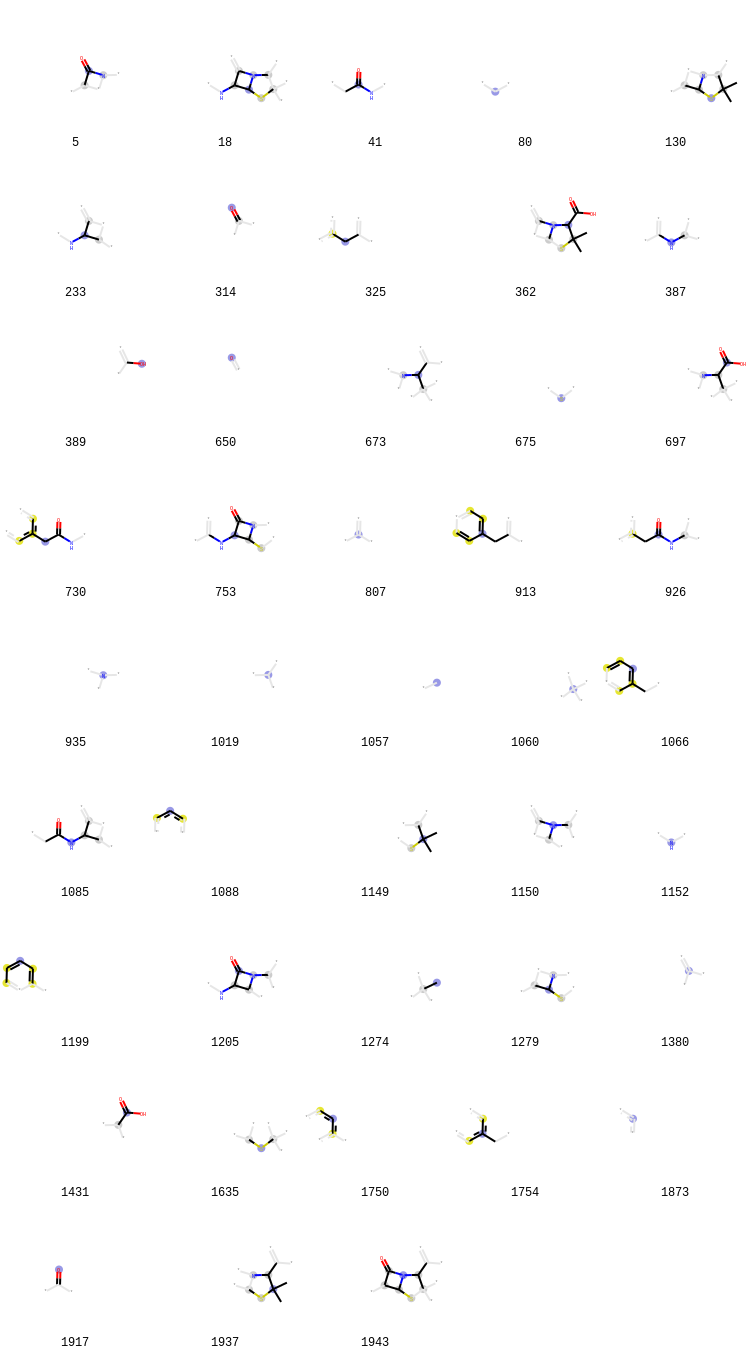

In [40]:
def fingerprints(molecule): # https://towardsdatascience.com/a-practical-introduction-to-the-use-of-molecular-fingerprints-in-drug-discovery-7f15021be2b1
  m = Chem.MolFromSmiles(molecule)
  bi = {}
  fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048, bitInfo=bi)
  fp_arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, fp_arr)
  np.nonzero(fp_arr)
  fp_bits = fp.GetOnBits()
  prints = [(m, x, bi) for x in fp_bits]
  return Draw.DrawMorganBits(prints, molsPerRow=5, legends=[str(x) for x in fp_bits])

fingerprints(penicillin)

In [43]:
def similarity(molecule1, molecule2): # fraction of fingerprints the set of two molecules have in common
    m1 = Chem.MolFromSmiles(molecule1)
    bi1 = {}
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, radius=2, nBits=2048, bitInfo=bi1)
    fp1_bits1 = fp1.GetOnBits()

    m2 = Chem.MolFromSmiles(molecule2)
    bi2 = {}
    fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, radius=2, nBits=2048, bitInfo=bi2)
    fp2_bits2 = fp2.GetOnBits()

    common = set(fp1_bits1) & set(fp2_bits2)
    combined = set(fp1_bits1) | set(fp2_bits2)

    return len(common)/len(combined) # recreation of DataStructs.TanimotoSimilarity

similarity(melatonin, penicillin)

0.1388888888888889

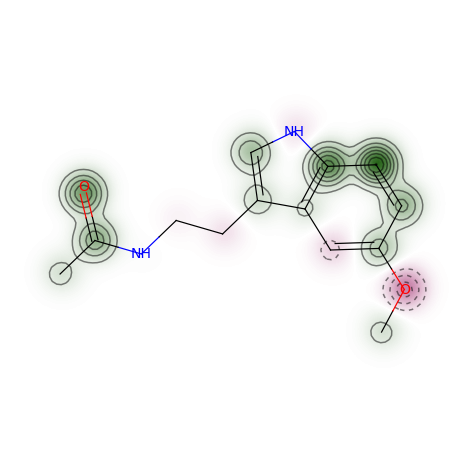

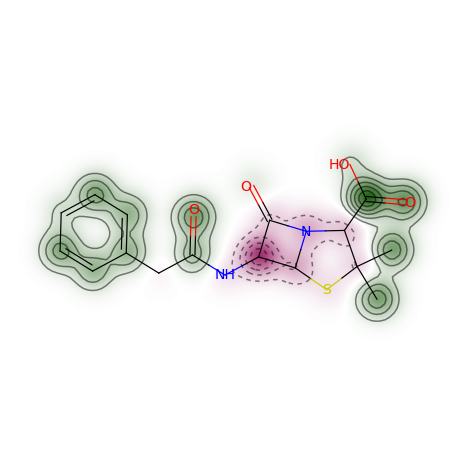

In [44]:
def similarity_map(molecule1, molecule2):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig1, maxweight1 = SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, SimilarityMaps.GetMorganFingerprint)
    fig2, maxweight2 = SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, SimilarityMaps.GetMorganFingerprint)

similarity_map(melatonin, penicillin)

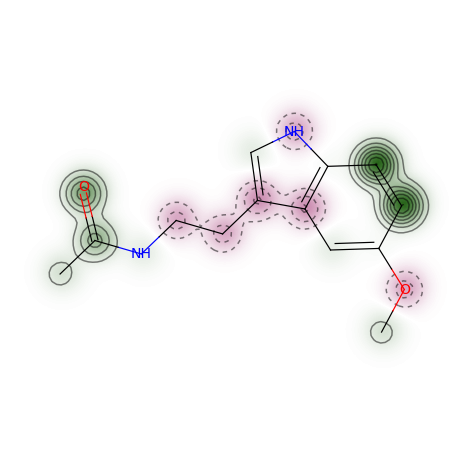

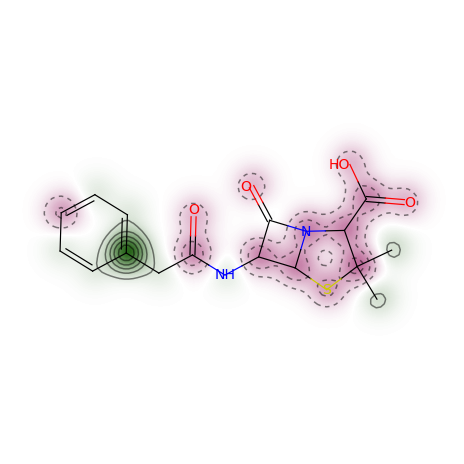

In [45]:
def similarity_map_tanimoto(molecule1, molecule2, r):

    m1 = Chem.MolFromSmiles(molecule1)
    m2 = Chem.MolFromSmiles(molecule2)

    fig3, maxweight3 = SimilarityMaps.GetSimilarityMapForFingerprint(m2, m1, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)
    fig4, maxweight4 = SimilarityMaps.GetSimilarityMapForFingerprint(m1, m2, lambda m,idx: SimilarityMaps.GetMorganFingerprint(m, atomId=idx, radius=r, fpType='count'), metric=DataStructs.TanimotoSimilarity)

similarity_map_tanimoto(melatonin, penicillin, 1)

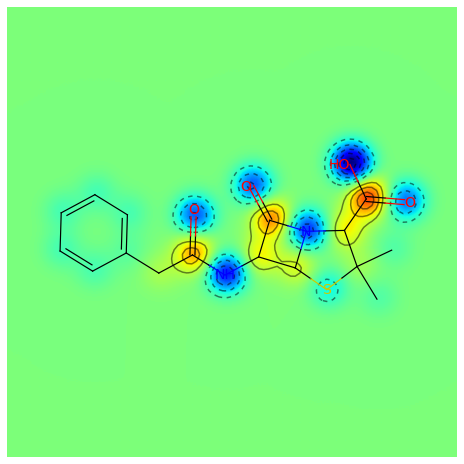

In [46]:
def gasteiger_partial_charges(molecule):
    mol = Chem.MolFromSmiles(molecule)
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)

gasteiger_partial_charges(penicillin)

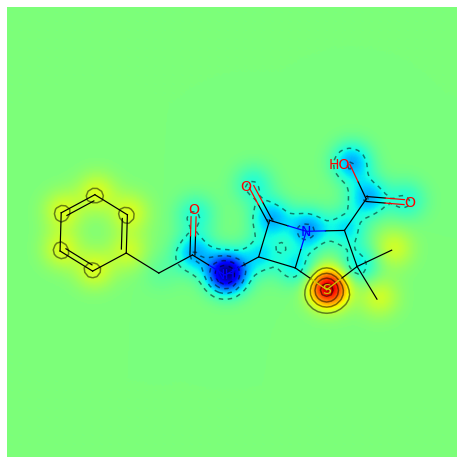

In [47]:
def crippen_contributions(molecule):
    mol = Chem.MolFromSmiles(molecule)
    contribs = rdMolDescriptors._CalcCrippenContribs(mol)
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in contribs], colorMap='jet', contourLines=10)

crippen_contributions(penicillin)

## Load Sample Data For Model Use

In [48]:
filey = open('pharmaceuticAI_all_compounds.smiles')
structures = [line[:-1] for line in filey]
print("Num Total Samples:", len(structures))
filey.close()

num_sampled = 10000
random.shuffle(structures)
data = structures[:num_sampled]
print("Num Sampled:", num_sampled)

data_structs = gen_structs(data)

Num Total Samples: 1591378
Num Sampled: 10000


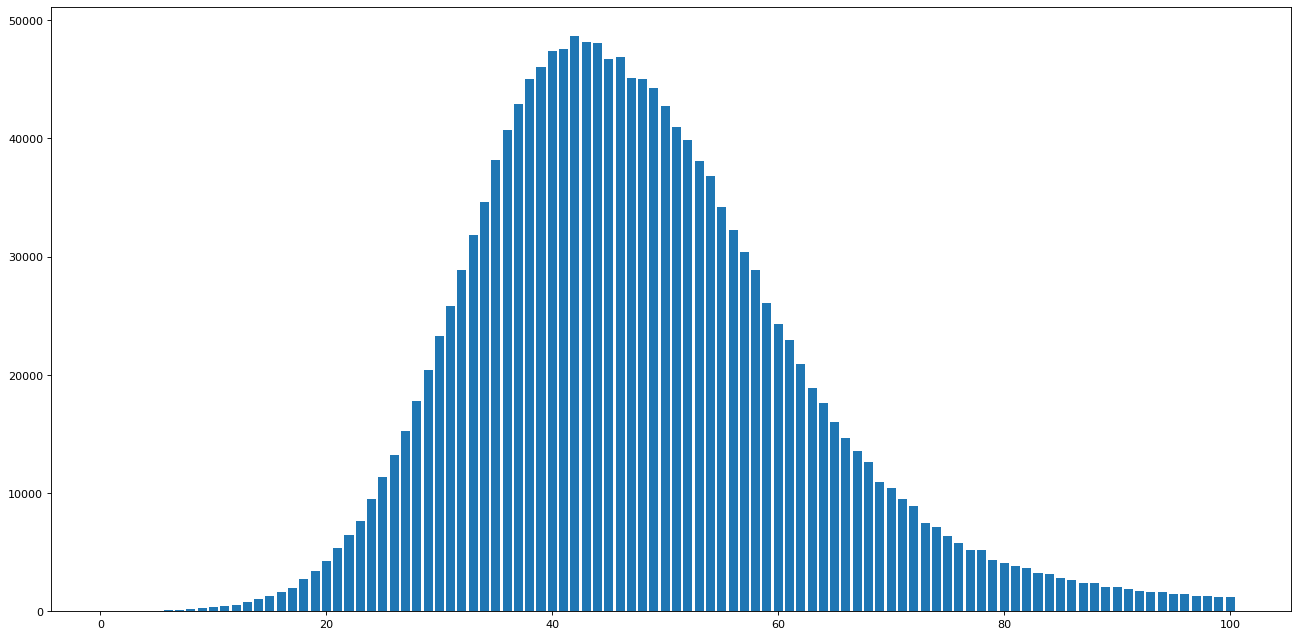

In [49]:
# distribution of molecule sequence lengths
lengths = [len(i) for i in structures]
c = Counter(lengths)
plt.figure(figsize=(20, 10), dpi=80)
plt.bar(c.keys(), c.values())
plt.show()

del structures

In [50]:
network_input, network_output = gen_data(data_structs)

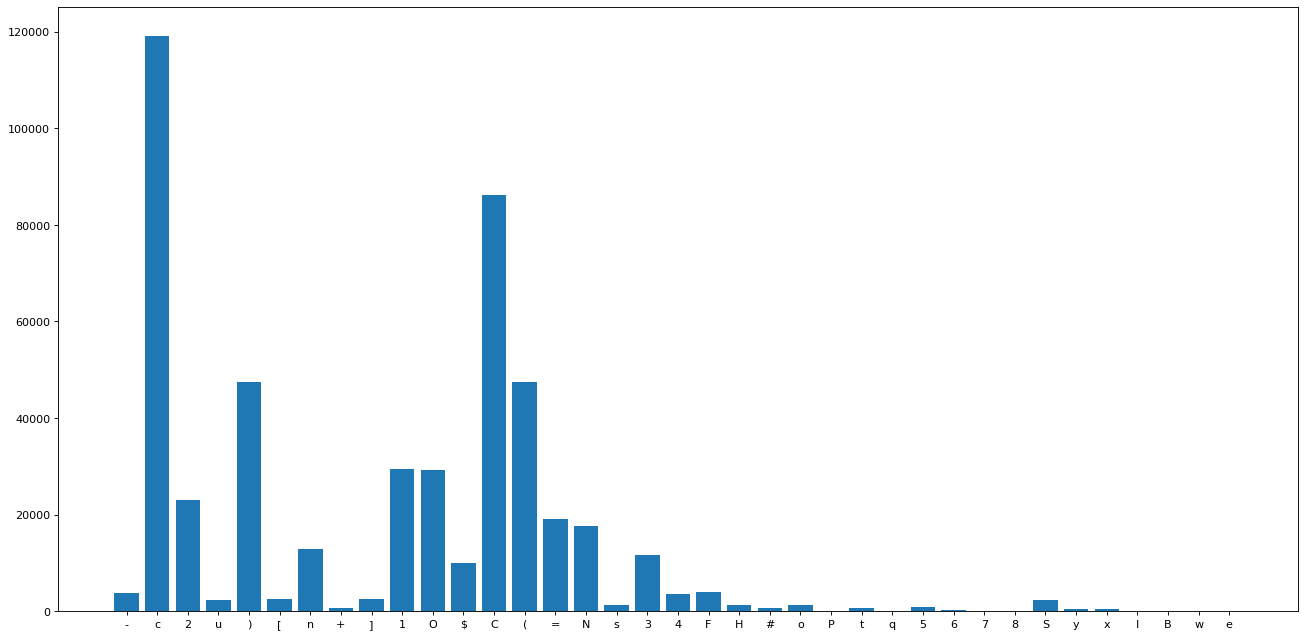

In [51]:
# class distributions data
c = Counter(network_output)
plt.figure(figsize=(20, 10), dpi=80)
plt.bar([int_to_element[i] for i in c.keys()], c.values())
plt.show()

In [52]:
network_output = one_hot(network_output)

## Generate Random Compounds

In [53]:
def generate(num_molecules=100):

    new_molecules = []

    while len(new_molecules) != num_molecules: # repeat until num_molecules molecules are generated

        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start] # grab a random sequence

        prediction_output = []

        try:
            start_idx = len(list(pattern)) - list(pattern)[::-1].index(element_to_int["$"]) - 1 # get index of last "$" (end token) which is the start of the incomplete molecule built upon
        except:
            start_idx = 0 # in case input does not even have an end token and is just one long molecule
        start_mol = list(pattern)[start_idx+1:]
        for element in start_mol:
            prediction_output.append(int_to_element[element]) # add incomplete molecule to start of output

        # build upon the incomplete molecule with predictions (predicting the next element of the sequence)
        # will stop at 100 predictions or until the end token "$" is predicted
        for element_index in range(100):
            prediction_input = np.reshape(pattern, (1, len(pattern)))
            prediction_input = prediction_input
            prediction = model.predict(prediction_input, verbose=0)
            index = np.argmax(prediction)
            result = int_to_element[index]
            if result == "$":
                break
            prediction_output.append(result)
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]

        output = "".join(prediction_output)

        for word, initial in single_to_double.items(): 
            output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements   

        if output not in new_molecules and test_molecule(output) and rule_of_five(output): # make sure that the molecules are unique, valid, and drug-like
              print("generated (randomly)", output)
              new_molecules.append(output)

    return new_molecules

In [54]:
new_molecules = generate(10)

generated (randomly) CC1=NN(c2ccc(C(=O)N3CCCC3)cc2)C(=O)N1Cc1ccc(OC(F)(F)F)cc1
generated (randomly) CCOC(=O)Cc1nc(-c2ccc(OC)cc2)c(C(=O)NC(C)C(=O)NC(C)C)s1
generated (randomly) CC#CCn1c(N2CCCC(N)C2)nc2ccccc21
generated (randomly) COc1cc2c(Oc3ccc(C(=O)NCCN4CCOCC4)cc3)cccc2cc1OC
generated (randomly) c1ccc(C2CN3CCCC3c3cc(OCCCN4CCOCC4)ccc32)cc1
generated (randomly) NC(=O)c1cccc2c(NCc3ccccc3)cc(NC(=O)c3ccccc3)cc12
generated (randomly) Cn1nnnc1SC1CCCN(c2nc(N)nc3ccccc23)C1
generated (randomly) O=C(NO)c1ccc(N2CC3CN(Cc4ccccc4)CC3C2)cc1
generated (randomly) CC(=O)c1ccc(NC(=O)C2CCCN2C(=O)C(C)NC(=O)C(C)C)cc1
generated (randomly) Nc1nc(SCCc2ccccc2)nc2ccccc12


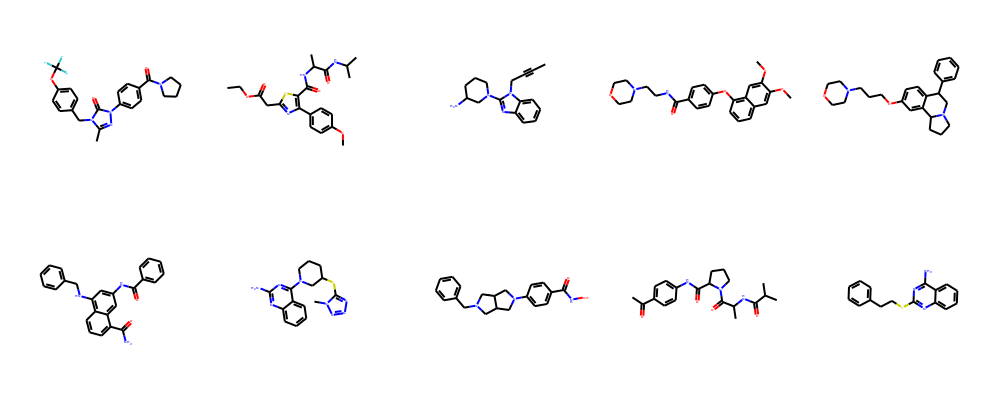

In [55]:
draw_list_compounds(new_molecules)

## Complete The Rest Of A Molecule 

In [68]:
def complete_molecule(inp):

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    found = False
    while not found:
        start = np.random.randint(0, len(network_input)-1)
        sample = network_input[start]
        if int_to_element[np.round(sample[-1])] == "$":
            found = True

    sample = sample[len(inp):sequence_length]

    net_in = []
    for i in sample:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_input = np.reshape(net_in, (1, sequence_length))[0]

    pred_out = []
    for element_index in range(100):
        net_input = np.reshape(net_input, (1, sequence_length))
        prediction = model.predict(net_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_element[index]
        pred_out.append(result)
        net_input = np.append(net_input, index)
        net_input = net_input[1:len(net_input)]

    output = "".join(pred_out)

    for word, initial in single_to_double.items(): 
        output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements

    end_molecule = ""
    for i in range(0, len(output)):
        if output[i] == "$":
          end_molecule = output[:i]
          break

    molecule = inp + end_molecule
    return molecule

In [ ]:
melatonin

'COC1=CC2=C(NC=C2CCNC(C)=O)C=C1'

In [ ]:
molecule = complete_molecule(str(input()))
print(molecule)

COC1=CC2=C(NC=C2C
COC1=CC2=C(NC=C2C)C(=O)C(C)(C)C1=O


In [ ]:
analyze_compound(molecule)

Molecule Weight: 233.26699999999997 g/mol
Num Atoms: 17
LogP: 2.1020199999999996
TPSA: 59.160000000000004


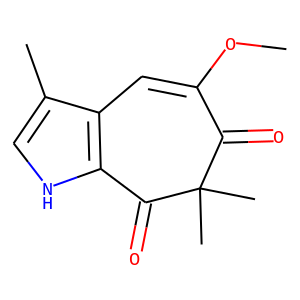

In [ ]:
draw_compound(molecule)

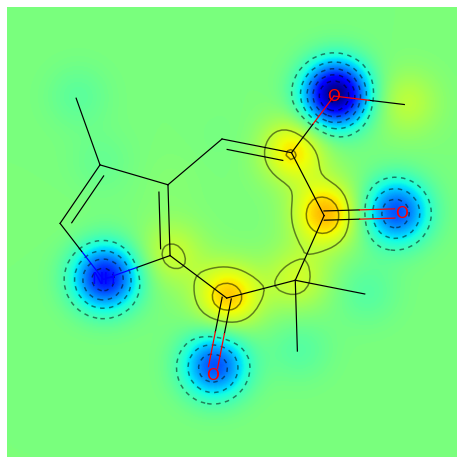

In [ ]:
gasteiger_partial_charges(molecule)

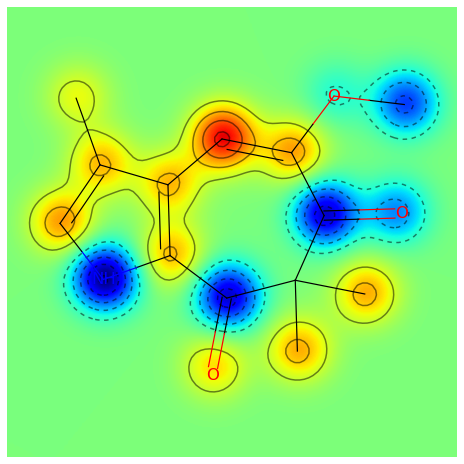

In [ ]:
crippen_contributions(molecule)

## Generate Compounds Targetting Coronavirus Proteins

In [56]:
target = new_client.target
target_query = target.search('coronavirus') # search for target protein
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,14.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,14.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,5.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859


In [57]:
selected_target = targets.target_chembl_id[4] # SARS coronavirus 3C-like proteinase	
selected_target

'CHEMBL3927'

In [58]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="Inhibition")
df = pd.DataFrame.from_dict(res)
df.head(20)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1480934,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,BAO_0000201,BAO_0000357,single protein format,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL372889,None,CHEMBL372889,None,False,http://qudt.org/vocab/unit#Percent,384102,=,1,True,=,None,Inhibition,%,None,25.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,25.0
1,None,1481062,[],CHEMBL832053,In vitro percent inhibition against SARS coron...,B,BAO_0000201,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc(I)cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL188484,None,CHEMBL188484,None,False,http://qudt.org/vocab/unit#Percent,383987,=,1,True,=,None,Inhibition,%,None,13.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,13.0
2,None,1481063,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,BAO_0000201,BAO_0000357,single protein format,COc1ccc2c(c1)C(=O)C(=O)N2Cc1cc2ccccc2o1,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL362781,None,CHEMBL362781,None,False,http://qudt.org/vocab/unit#Percent,383988,=,1,True,=,None,Inhibition,%,None,13.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,13.0
3,None,1481064,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,BAO_0000201,BAO_0000357,single protein format,O=C1C(=O)N(Cc2cc3ccccc3o2)c2ccc([N+](=O)[O-])cc21,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL191322,None,CHEMBL191322,None,False,http://qudt.org/vocab/unit#Percent,384074,=,1,True,=,None,Inhibition,%,None,24.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,24.0
4,None,1481067,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,BAO_0000201,BAO_0000357,single protein format,Nc1cccc2c1N(Cc1cc3ccccc3s1)C(=O)C2=O,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL363243,None,CHEMBL363243,None,False,http://qudt.org/vocab/unit#Percent,384178,=,1,True,=,None,Inhibition,%,None,31.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,31.0
5,None,1481072,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,BAO_0000201,BAO_0000357,single protein format,Cc1cc2c(c([N+](=O)[O-])c1)N(Cc1cc3ccccc3s1)C(=...,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL365677,None,CHEMBL365677,None,False,http://qudt.org/vocab/unit#Percent,384006,=,1,True,=,None,Inhibition,%,None,39.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,39.0
6,None,1481073,[],CHEMBL831837,In vitro percent inhibition against SARS coron...,B,BAO_0000201,BAO_0000357,single protein format,COc1ccc2c(c1)C(=O)C(=O)N2Cc1cc2ccccc2s1,None,None,CHEMBL1139624,Bioorg. Med. Chem. Lett.,2005,None,CHEMBL188811,None,CHEMBL188811,None,False,http://qudt.org/vocab/unit#Percent,384007,=,1,True,=,None,Inhibition,%,None,27.0,CHEMBL3927,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,Inhibition,%,UO_0000187,None,27.0
7,None,1481094,[],CHEMBL834180,In vitro percent inhibition against SARS coron...,B,BAO_0

In [59]:
df.assay_description.unique() # make sure all of them are inhibitors - inhibitors stop the function of the protein (turn it off - opposite of activators)

array(['In vitro percent inhibition against SARS coronavirus main protease (SARS CoV 3C-like protease) at 20 uM',
       'In vitro percent inhibition against SARS coronavirus main protease (SARS CoV 3C-like protease)',
       'Inhibition of Mpro in SARS-CoV at 100uM',
       'Inhibition of Mpro in SARS-CoV at 100 uM in FRET-based assay',
       'Inhibition of Mpro in SARS-CoV at 100 uM in HPLC assay',
       'Inhibition of SARS CoV 3C-like protease at 100 uM',
       'Inhibition of SARS coronavirus main protease at 10 uM',
       'Inhibition of SARS coronavirus His-3C-like protease at 100 uM',
       'Inhibition of SARS coronavirus 3C-like protease at 1 uM',
       'Inhibition of SARS-CoV 3CLpro expressed in Escherichia coli BL21 (DE3) using Dabcyl-KNSTLQSGLRKE-Edan as substrate at 200 uM after 60 mins by FRET analysis',
       'Inhibition of SARS-CoV PLpro deubiququitination expressed in Escherichia coli BL21 (DE3) using Arg-Leu-Arg-Gly-Gly-AMC as substrate at 200 uM by fluorescence a

In [60]:
target_inhibit_list = df.canonical_smiles 
target_inhibit_list = list(set(target_inhibit_list)) # remove duplicates
print(target_inhibit_list)

['O=C(Oc1cncc(Cl)c1)c1ccccc1', 'O=C(OCc1cncc(Br)c1)c1ccco1', 'O=C(Nc1ccc(F)cn1)c1cccs1', 'COC(=O)C1CN1CCCC[C@H](NC(=O)OCc1ccccc1)C(=O)OC', 'COC(=O)C1CN1[C@@H](C)C(=O)OC', 'CCCN1C(=O)C(=O)c2cc(C(=O)OC)ccc21', 'O=C(Oc1ccc(Cl)nc1)c1cccs1', 'CN1C(=O)C(=O)c2cc(C(=O)O)ccc21', 'O=C(Nc1cccnc1Cl)c1cccs1', 'O=C(Nc1ccc(Cl)cn1)c1cccs1', 'O=Cc1ccco1', 'C[C@H]1[C@@H](C(=O)N[C@@H](Cc2ccccc2)C(=O)OCc2ccccc2)N1Cc1ccccc1', 'Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C(N)=O)ccc21', 'CCCN1C(=O)C(=O)c2cc(C(=O)O)ccc21', 'O=C(Oc1ccco1)c1cccnc1', 'O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Cl)ccc(Cl)c21', 'COc1ccc([N+](=O)[O-])c(S(=O)(=O)c2ccccc2)n1', 'O=Cc1ccc(-c2ccc(Cl)cc2)o1', 'Clc1cncc(OCc2ccco2)c1', 'O=C(Oc1cncc(Cl)c1)c1cc2ccccc2[nH]1', 'Nc1cccc2c1N(Cc1cc3ccccc3s1)C(=O)C2=O', 'C[C@H]1O[C@H]1C(=O)N[C@H](Cc1ccccc1)C(=O)OCc1ccccc1', 'O=C(O)c1ccc2c(c1)C(=O)C(=O)N2Cc1ccccc1', 'COc1ccc2c(c1)C(=O)C(=O)N2Cc1cc2ccccc2o1', 'CC1C(C(=O)N[C@@H](Cc2ccccc2)C(=O)OCc2ccccc2)N1Cc1ccccc1', 'Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1', 'CCOC(=O)[C

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


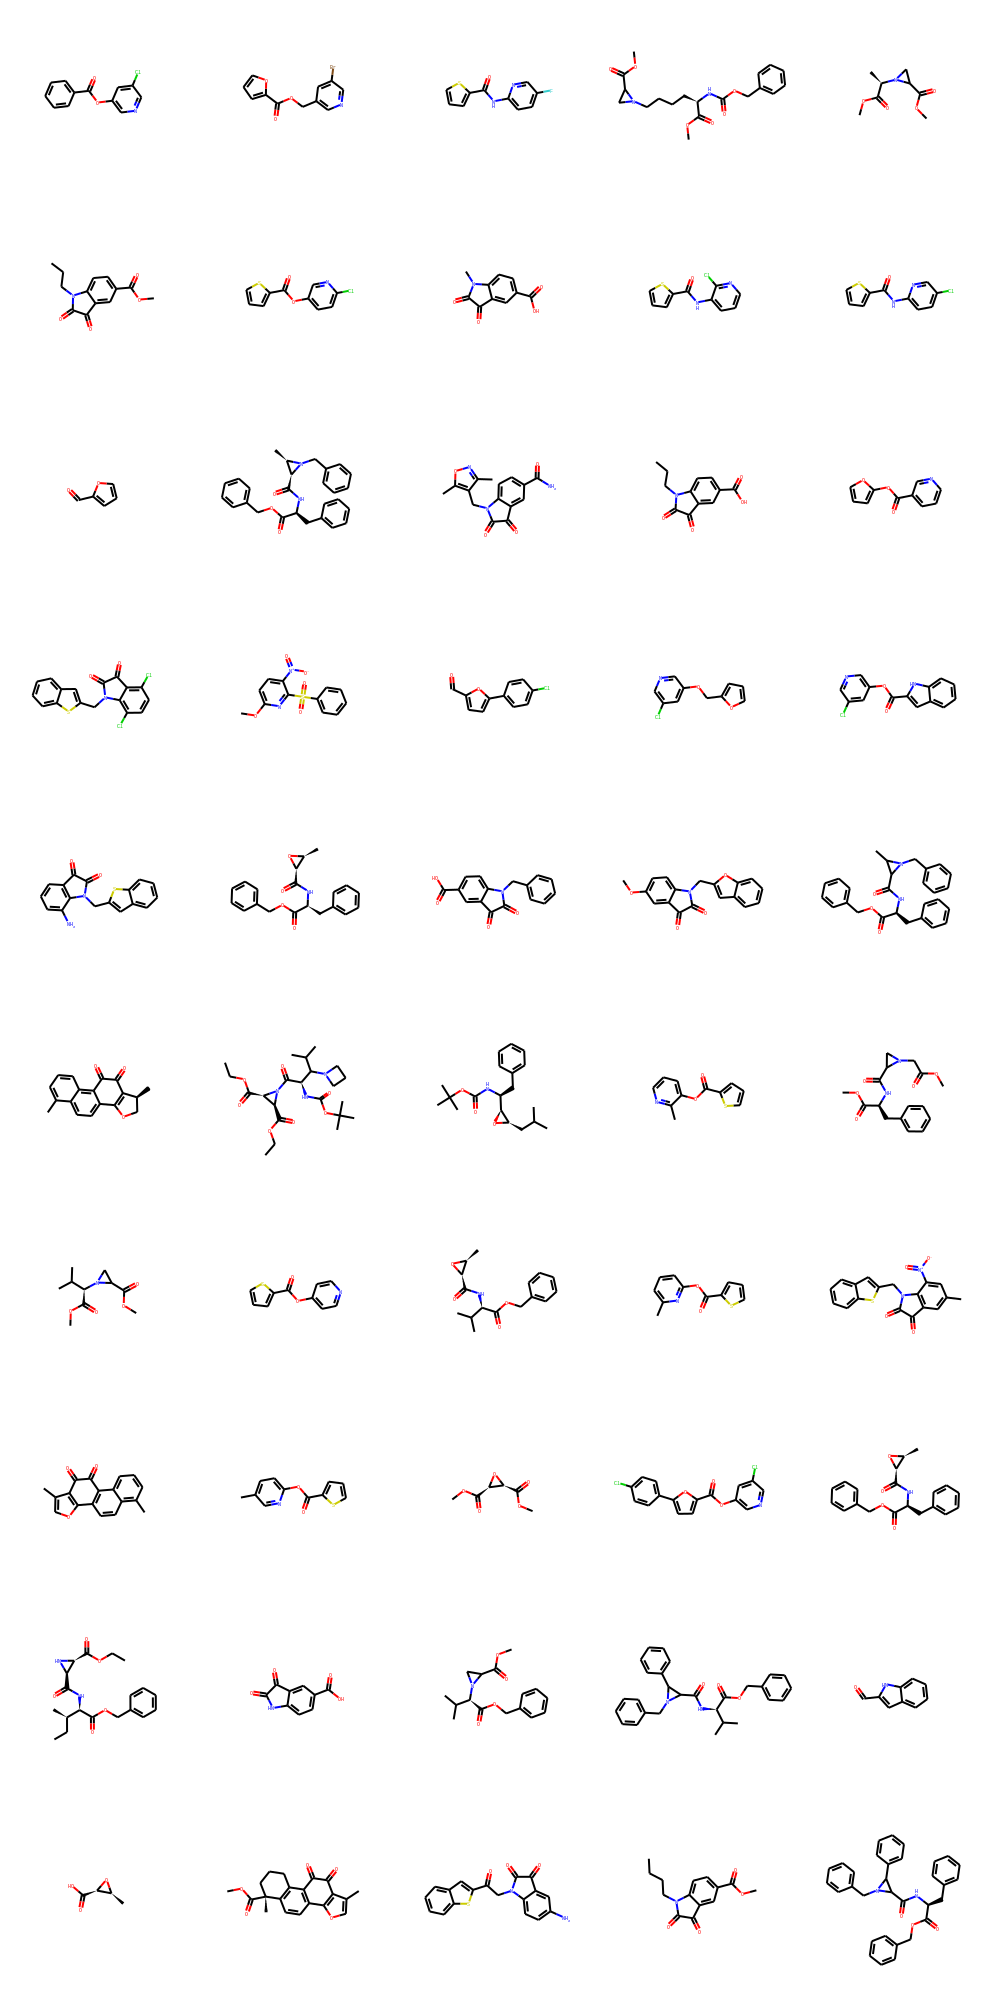

In [61]:
draw_list_compounds(target_inhibit_list)

In [70]:
def generate_methodical(target_inhibitors_list):

    target_inhibitors = [inhibitor.replace("/", "").replace("@", "").replace("\\", "").replace(".", "") for inhibitor in target_inhibitors_list]

    inhibitors_sequences = []
    for mol in target_inhibitors:
        for cutoff in range(1, len(mol)): 
            inhibitors_sequences.append(mol[:cutoff])

    new_molecules = []
    for seq in inhibitors_sequences:
        new_mol = complete_molecule(seq)
        if new_mol not in new_molecules: # make sure that the molecules are unique
          if test_molecule(new_mol) and rule_of_five(new_mol): # make sure that the molecules are valid and drug-like
              new_molecules.append(new_molecules.append(new_mol))
              print("generated (methodically)", new_mol)

    return new_molecules

In [ ]:
def generate_methodical_2(target_inhibitors_list): 

    random.shuffle(list(target_inhibitors_list)) # randomize the order in which the molecules will be converted into sequences

    target_inhibit_str = ""
    for compound in target_inhibitors_list:
        target_inhibit_str += str(compound) + "$" # add end tokens after each molecule
    for word, initial in double_to_single.items(): 
            target_inhibit_str = target_inhibit_str.replace(word, initial) # replace double-letter elements to single-letter for model input
    target_inhibit_structs = [element for element in target_inhibit_str if element != '/' and element != '@' and element != '\\' and element != '.'] # compounds data does not include these symbols

    network_inp = []

    if len(target_inhibit_structs) < sequence_length: # if the length of all the existing inhibitors are less than the sequence length, use a random data sampled sequence to complete the input sequences

        found = False
        while not found: # find sequence with the end token "$" at the end
            start = np.random.randint(0, len(network_input)-1)
            sample = network_input[start]
            if int_to_element[np.round(sample[-1])] == "$":
                found = True

        sample_structs = [int_to_element[np.round(i)] for i in sample]

        inhibit_structs = []
        for cutoff in range(1, len(target_inhibit_structs)): # use the sampled sequence to complete the input sequences
            sample_cut = sample_structs[cutoff:]
            target_inhibit_structs_cut = target_inhibit_structs[:cutoff]
            inhibit_structs.append(sample_cut + target_inhibit_structs_cut)

        for i in range(0, len(inhibit_structs)):
            sequence_in = inhibit_structs[i]
            network_inp.append([element_to_int[char] for char in sequence_in])

    else: # if the length of all the existing inhibitors is enough to have a full input sequence, use the 

        for i in range(0, len(target_inhibit_structs) - sequence_length):
            sequence_in = target_inhibit_structs[i:i + sequence_length]
            network_inp.append([element_to_int[char] for char in sequence_in])
            
    n_patterns = len(network_inp)

    network_inp = np.reshape(network_inp, (n_patterns, sequence_length))

    new_molecules = []  

    for pattern in network_inp:

        prediction_output = []

        try:
            start_idx = len(list(pattern)) - list(pattern)[::-1].index(element_to_int["$"]) - 1 # get index of last "$" (end token) which is the start of the incomplete molecule built upon
        except:
            start_idx = 0 # in case input does not even have an end token and is just one long molecule
        start_mol = list(pattern)[start_idx+1:]
        for element in start_mol:
            prediction_output.append(int_to_element[element]) # add incomplete molecule to start of output

        # build upon the incomplete molecule with predictions (predicting the next element of the sequence)
        # will stop at 100 predictions or until the end token "$" is predicted
        for element_index in range(100):
            prediction_input = np.reshape(pattern, (1, len(pattern)))
            prediction = model.predict(prediction_input, verbose=0)
            index = np.argmax(prediction)
            result = int_to_element[index]
            if result == "$":
                break
            prediction_output.append(result)
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]

        output = "".join(prediction_output)

        for word, initial in single_to_double.items(): 
            output = output.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements

        if output not in new_molecules: # make sure that the molecules are unique
            if test_molecule(output) and rule_of_five(output): # make sure that the molecules are valid and drug-like
                new_molecules.append(output)
                print("generated (methodically)", output)

    return new_molecules

In [ ]:
new_molecules = generate_methodical(target_inhibit_list)

/usr/local/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


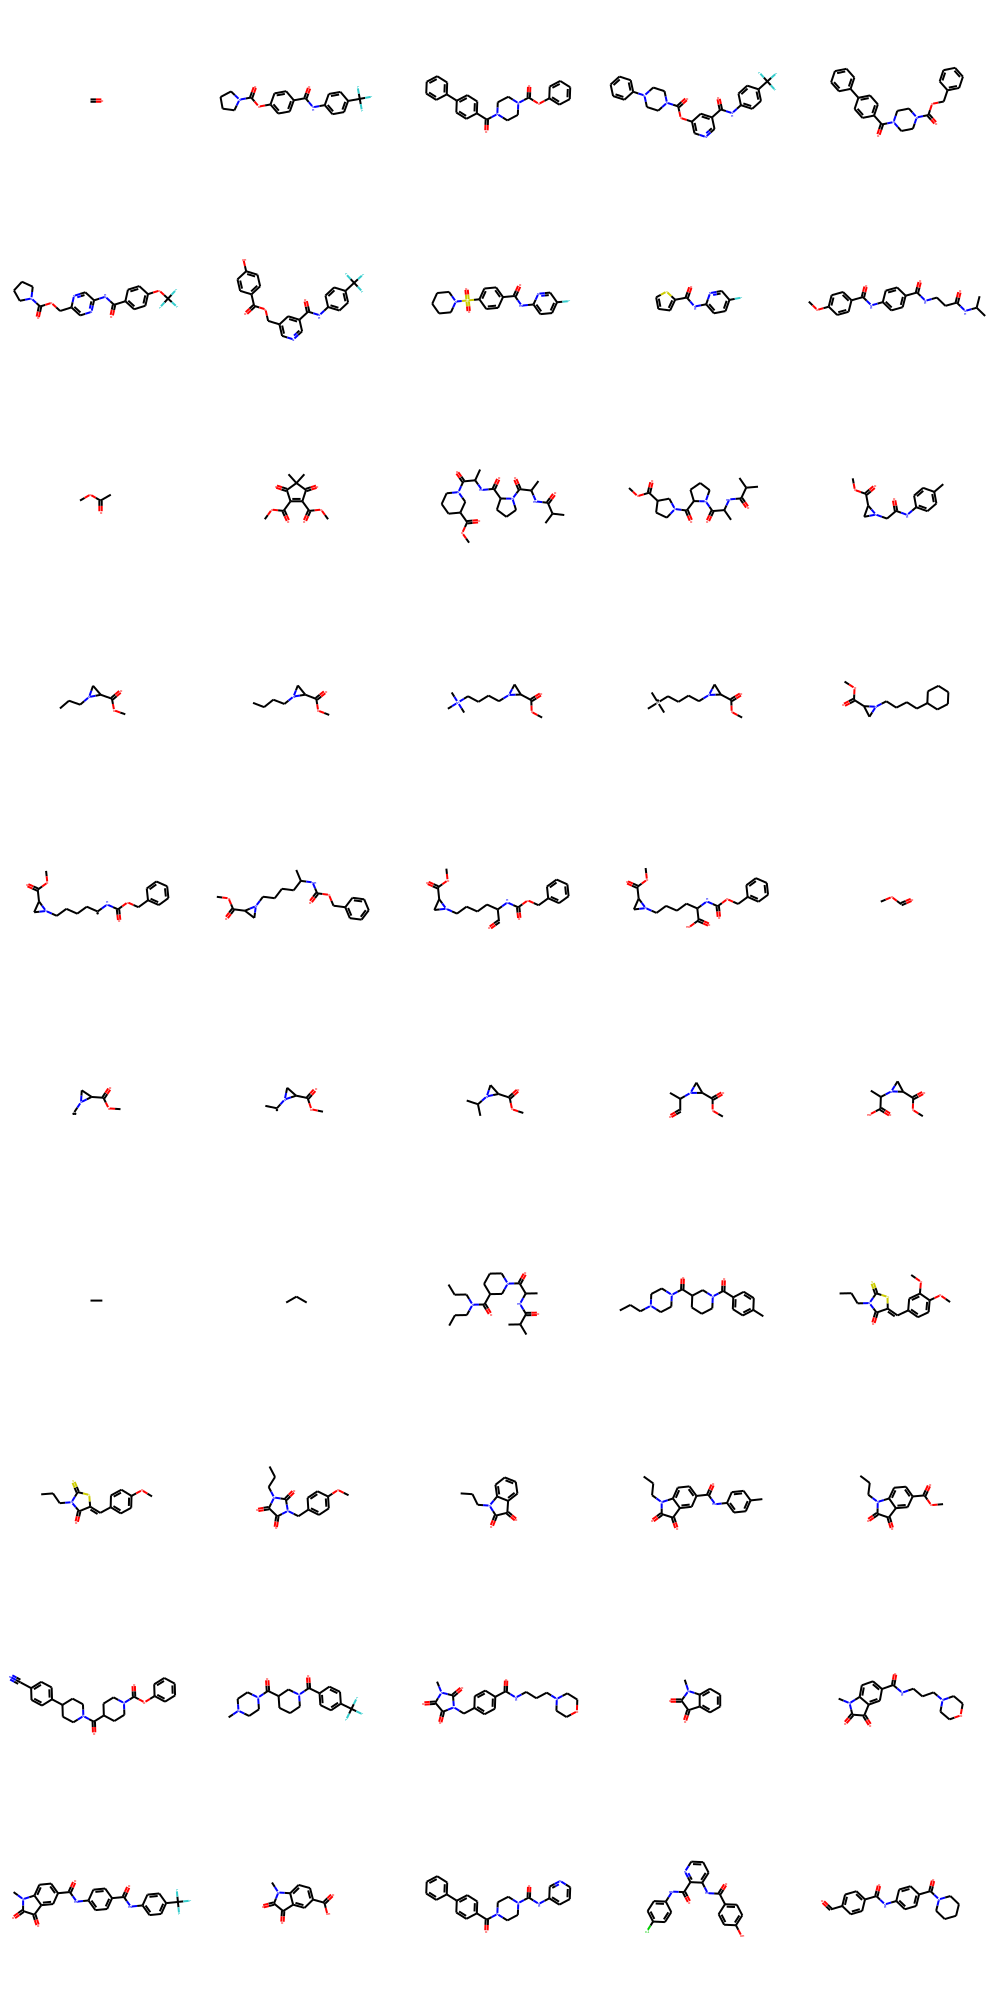

In [82]:
draw_list_compounds(new_molecules[:100])

## Augment Existing Molecule

In [ ]:
def complete(inp): # helper method for augment - returns a prediction in place of the removed element

    for word, initial in double_to_single.items(): 
        inp = inp.replace(word, initial) # replace double-letter elements to single-letter for model input

    net_inp = []

    for i in range(0, len(inp)):
        seq_in = inp[i]
        net_inp.append([element_to_int[char] for char in seq_in])

    found = False
    while not found: # find sequence with the end token "$" at the end
        start = np.random.randint(0, len(network_input)-1)
        pattern = network_input[start]
        if int_to_element[np.round(pattern[-1])] == "$":
            found = True

    net_in = []
    for i in pattern[len(inp):sequence_length]:
      net_in.append(i)
    for j in net_inp:
      net_in.append(j[0])

    net_in = np.reshape(net_in, (1, sequence_length))

    prediction = model.predict(net_in, verbose=0) # make prediction
    index = np.argmax(prediction)
    result = int_to_element[index]

    return result

def augment(compound, num_changes): # could enhance the pharmacokinetics and bioactivity of the compound

    for word, initial in double_to_single.items(): 
        compound = compound.replace(word, initial) # replace double-letter elements to single-letter for model input

    changes = np.random.randint(1, num_changes+1)
    for i in range(0, changes): # randomly removes certain amount of random elements in SMILES string compound and replaces them with prediction
        ind = np.random.randint(0, len(compound))
        changed = compound[ind]
        new_compound = compound[:ind]
        
        result = complete(new_compound)
        if result == "$":
            return compound[:ind] # if an end token is predicted, return the part of the compound up to the changed index
        else:
            compound = compound[:ind] + result + compound[ind+1:] # add the prediction in place of the removed element

    return compound # return the augmented compound after all the changes have been made

def augment_repeat(inp, sim, changes, max_try):

  if len(inp) > sequence_length:
      inp = inp[:sequence_length]

  tries = 0
  while tries < max_try: # keep trying to make augmented molecules until the model has exceeded the max number of tries (max_try)

      augmented = augment(inp, changes)
      tries += 1 
      for word, initial in single_to_double.items(): 
        augmented = augmented.replace(word.lower(), initial) # replace single-letter elements back to original double-letter SMILES notation elements
      try:
          if test_molecule(augmented) and augmented != inp and rule_of_five(augmented): # make sure that the molecules are valid and drug-like
              s = similarity(inp, augmented) # calculate similarity between the original molecule and the augmented molecule
              if sim < s < 1: # make sure the molecule follows the similarity threshold
                  print("augmented", inp, "-->", augmented, "with similarity", s)
                  return augmented
      except:
          continue

  print("could not augment", inp, "within", tries, "tries")

def aug_list(inp_list, similarity=0.2, max_changes=20, max_tries=100):

    molecules = [augment_repeat(compound.replace('/', "").replace('@', "").replace('\\', "").replace('.', ""), similarity, max_changes, max_tries) for compound in inp_list]
    molecules = list(set(molecules)) # remove duplicates
    molecules = [i for i in molecules if i] 
    return molecules

In [ ]:
melatonin

'COC1=CC2=C(NC=C2CCNC(C)=O)C=C1'

In [ ]:
original = str(input())
augmented = aug_list([original])[0]

COC1=CC2=C(NC=C2CCNC(C)=O)C=C1
augmented COC1=CC2=C(NC=C2CCNC(C)=O)C=C1 --> COC1CCC2=C(NC=C2CCNC(C)=O)C=C1 with similarity 0.4067796610169492


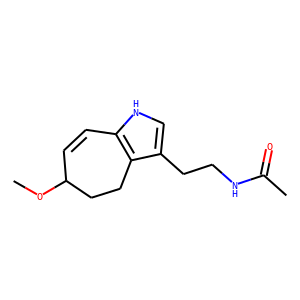

In [ ]:
draw_compound(augmented)

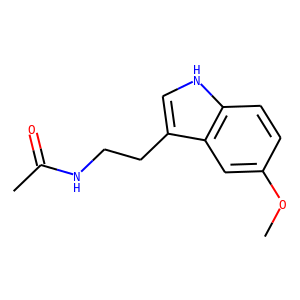

In [ ]:
draw_compound(original)

In [ ]:
similarity(original, augmented)

0.4067796610169492

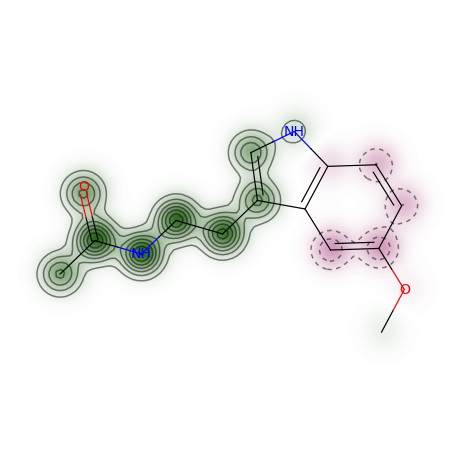

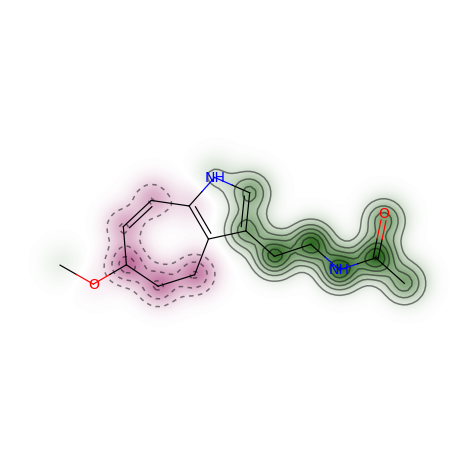

In [ ]:
similarity_map(original, augmented)

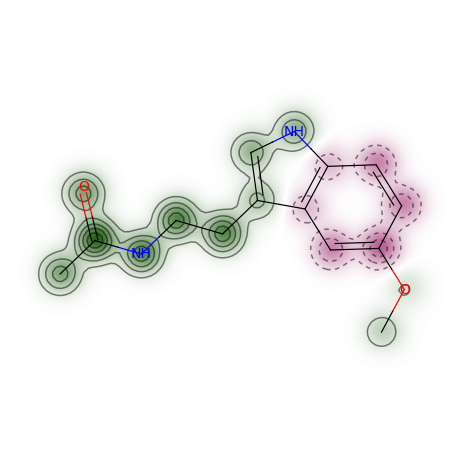

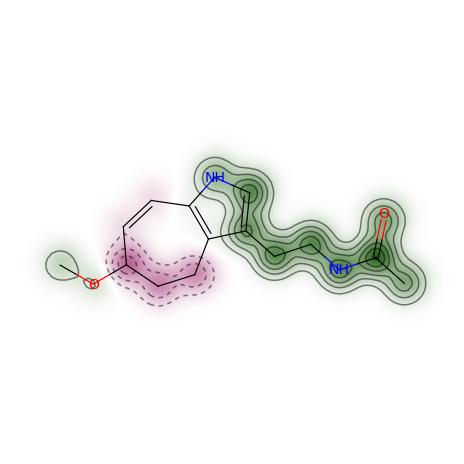

In [ ]:
similarity_map_tanimoto(original, augmented, 1)